# Mitigation

In [1]:
import collections
import math
import numpy as np
import pandas as pd
import scipy
from scipy.special import perm # for nPk 
from sympy.functions.combinatorial.numbers import stirling
import matplotlib.pyplot as plt 


Bad key text.latex.unicode in file C:\Users\mirey\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file C:\Users\mirey\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file C:\Users\mirey\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need 

## IDEAL BAYES

In [3]:
def uni_ore_bayes(n, k):
    outputs = 0
    for c in range(n):
        if k < c+1:
            break
        outputs = outputs + (stirling(n, c+1) * math.factorial(c+1))
    inputs = pow(k, n)
    return outputs / inputs

## IDEAL BUCKET

In [4]:
def trailing_zero(n):
    x = int(bin(n)[2:])
    count = 0
    while ((x & 1 ) == 0):
        x = x >> 1
        count += 1
    return count

def report_number(K, I):
    r = [[0]* (I + 1) for _ in range(K+1)]
    r[1][1] = 1
    for k in range(2, K+1):
        b = trailing_zero(k-1)
        for i in range(1, I+1):
            r[k][i] = r[k-1][i] + r[k-1][i-1] - r[k-1- int(math.pow(2,b))][i-1]
    return r

In [5]:
def c_bell(i, n):
    c = 0
    for u in range(0, i+1):
        c = c + pow(-1, (i-u)) * scipy.special.comb(i, u, exact = True) * pow(u, n)
    return c

def m_bell(i, n):
    return stirling(n, i) * math.factorial(i)

In [6]:
def g4(i, b, s):
    f = math.floor(i/b)
    m = i % b
    left = pow( (scipy.special.comb(s, f+1, exact = True)) , m)
    right = pow( (scipy.special.comb(s, f, exact = True)) , (b-m))
    return left * right

def cat4(n, k, b):
    prior = pow(k, -n)
    v = 0
    for i in range(1,min(n, k)+1):
        v = v + m_bell(i, n) * g4(i, b, k/b)
    return v * prior

def big_cat4(n, k, b): # logs to avoid overflow. Cat's ordered bell since s2 hits max recurrsion depth n = 1k #fixed this with sympy update but won't change
    prior = pow(k, n) # k, -n
    v = 0
    for i in range(1,min(n, k)+1):
        v = v + c_bell(i, n) * g4(i, b, k/b)
    v_log = math.log2(v)
    prior_log = math.log2(prior)
    r_log = v_log - prior_log
    r = pow(2, r_log)
    return r

without mitigation

In [7]:
print("tests comparing p vuln")
n = 3000
k = 64
b = 8 # the number of buckets
print("Bayes: ")
print(round(uni_ore_bayes(n, k), 5))
print("Bucket, b = 8: ")
print(big_cat4(n, k, b))

tests comparing p vuln
Bayes: 
1.00000000000000
Bucket, b = 8: 
1.0


In [59]:
n = 2000
k = 512
b_list = [512, 256, 128, 64, 32, 16, 8, 4, 2]# the number of buckets
for b in b_list:
    print("Bucket, b = ", b)
    c = big_cat4(n, k, b)
    sc_c = "{:.2e}".format(c)
    print(sc_c)

Bucket, b =  512
2.06e-05
Bucket, b =  256
2.11e-05
Bucket, b =  128
2.21e-05
Bucket, b =  64
2.45e-05
Bucket, b =  32
3.12e-05
Bucket, b =  16
6.73e-05
Bucket, b =  8
1.46e-03
Bucket, b =  4
2.93e-02
Bucket, b =  2
2.47e-01


In [28]:
print("tests comparing p vuln with 3 bits of mitigation")
n = 3000
k = 64
b = 8 # the number of buckets
print("Bayes: ")
print(big_cat4(n, 512, k)) # values now range from 0-511 (9 bits), k buckets (the original k values)
print("Bucket, b = 8: ")
print(big_cat4(n, 512, b)) # k has increased to 2^9, still only care about first b buckets

tests comparing p vuln with 3 bits of mitigation
Bayes: 
vlog:  26997.91771315176
prior_log 27000.0
0.23613980436497264
Bucket, b = 8: 
vlog:  26998.178503987034
prior_log 27000.0
0.28292743552547456


### General Graph Code

In [7]:
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
font_choice = 14
plt.rcParams.update(plt.rcParamsDefault)
rc_fonts = {
    "text.usetex": True,
    "font.size": font_choice,
    'mathtext.default': 'regular',
    'axes.titlesize': font_choice,
    "axes.labelsize": font_choice,
    "legend.fontsize": font_choice,
    "xtick.labelsize": font_choice,
    "ytick.labelsize": font_choice,
    'figure.titlesize': font_choice,
    'figure.figsize': (8,5.25),
    'text.latex.preamble': [r'\usepackage{amsmath,nicefrac, sansmath}', 
                            r'\sansmath'],
    "font.family": "sans-serif",#"font.sans-serif": "computer modern",
    }
mpl.rcParams.update(rc_fonts)

C:\Users\mirey\AppData\Local\Continuum\anaconda3\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


#### Bayes- Function of n, mitigation df

In [20]:
def df_mit(n_range, k, b): 
    kb = k * pow(2, b)
    n = 0
    n_list = []
    postIdeal_list = []
    mitIdeal_list = []
    for x in range(n_range):
        n = n + 1
        n_list.append(n)
        ideal = uni_ore_bayes(n, k)
        postIdeal_list.append(ideal)
        mit = big_cat4(n, kb, k) # b = k = 8
        mitIdeal_list.append(mit)
    df = pd.DataFrame(
        {'n':n_list,
         'postIdeal':postIdeal_list,
         'mitIdeal':mitIdeal_list
        }
    )
    return df

In [25]:
def df_mit_range(n_range, k): # hardcoded for b = 1-3 
    kb1 = k * pow(2, 1)
    kb2 = k * pow(2, 2)
    kb3 = k * pow(2, 3)
    n = 0
    n_list = []
    postIdeal_list = []
    mitIdeal_list1 = []
    mitIdeal_list2 = []
    mitIdeal_list3 = []
    for x in range(n_range):
        n = n + 1
        if n % 20 == 0: print("n : ", n)
        n_list.append(n)
        ideal = uni_ore_bayes(n, k)
        postIdeal_list.append(ideal)
        mit1 = big_cat4(n, kb1, k)
        mitIdeal_list1.append(mit1)
        mit2 = big_cat4(n, kb2, k)
        mitIdeal_list2.append(mit2)
        mit3 = big_cat4(n, kb3, k)
        mitIdeal_list3.append(mit3)
    df = pd.DataFrame(
        {'n':n_list,
         'postIdeal':postIdeal_list,
         'mitIdeal1':mitIdeal_list1,
         'mitIdeal2':mitIdeal_list2,
         'mitIdeal3':mitIdeal_list3,
        }
    )
    return df

Run to generate dataframe. Takes time for large n and k

In [26]:
n_range = 30
k = 8
df_test = df_mit_range(n_range, k)

n :  20


In [18]:
df_brange64.to_csv(r'data\mit_bayes_n1000_k64.csv', index = None, header=True)

In [23]:
df_brangek64n3000.to_csv(r'data\mit_bayes_n3000_k64.csv', index = None, header=True)

In [13]:
df_brange.to_csv(r'data\mit_bayes_n1000_k128.csv', index = None, header=True)

Read from dataframe

In [2]:
df_bayes = pd.read_csv(r'data\mit_bayes_n3000_k64.csv')

In [6]:
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        try:
            num, denom = frac_str.split('/')
        except ValueError:
            return None
        '''
        try:
            leading, num = num.split(' ')
        except ValueError:
            return float(num) / float(denom)        
        if float(leading) < 0:
            sign_mult = -1
        else:
            sign_mult = 1
        #return float(leading) + sign_mult * (float(num) / float(denom))
        '''
        
        return (int(num) / int(denom))

convert_to_float('1/6')

In [7]:
df_bayes = df_bayes.assign(mitIdeal0 = lambda x: x['postIdeal'].apply(lambda y: convert_to_float(y)))

In [17]:
df_bayes.iloc[999]

n                                                         1000
postIdeal    1513456782005501189672625856798113061965403089...
mitIdeal1                                             0.951679
mitIdeal2                                           0.00503641
mitIdeal3                                          2.52275e-26
mitIdeal0                                             0.999991
Name: 999, dtype: object

works on DF with the mitIdeal0 column

In [141]:
def graph_bayes3(n_range, df):
    ax = plt.figure().gca()
    plt.plot('n', 'mitIdeal0',
             color='red',
             linestyle='dotted',
             data=df, 
             label="0 bits")
    plt.plot('n', 'mitIdeal1',
             data=df,
             color='orange',
             linestyle='dashed',
             label="1 bit")
    plt.plot('n', 'mitIdeal2',
             data=df,
             color='blue',
             linestyle='dashdot',
             label="2 bits")
    plt.plot('n', 'mitIdeal3',
             data=df,
             color='green',
             linestyle='solid',
             label="3 bits")
    
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('n')
    plt.xticks([500, 1000, 1500, 2000, 2500, 3000])
    plt.xlim(left = -15, right = n_range + 10)
    plt.ylabel('Bayes vulnerability')
    plt.ylim(bottom=-.1, top = 1.1)
    
    plt.title('Effect of Mitigation on Ideal ORE Bayes vulnerability, k = 64')
    plt.legend(loc='upper left')
    #plt.savefig('why.png')
    plt.show()
    plt.close()

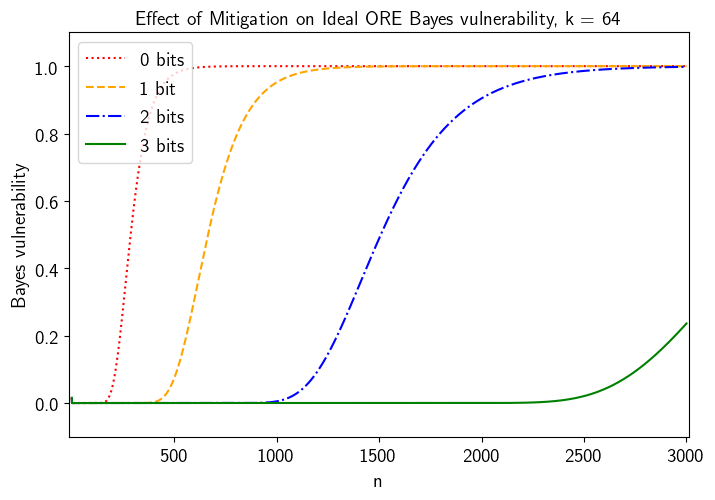

In [142]:
graph_bayes3(3000, df_bayes)

### BUCKETING MITIGATION

k = 8, b = 4, func of n. Ideal bucketing 0 added bits, 1 - 3 bits, match bayes

#### Bucket- Function of n, mitigation df

In [8]:
def df_mit_range_buck(n_range, k, b): # hardcoded for 1-3 added bits
    kb1 = k * pow(2, 1)
    kb2 = k * pow(2, 2)
    kb3 = k * pow(2, 3)
    n = 0
    n_list = []
    postIdeal_list = []
    mitIdeal_list1 = []
    mitIdeal_list2 = []
    mitIdeal_list3 = []
    for x in range(n_range):
        n = n + 1
        if n % 20 == 0: print("n: ", n)
        n_list.append(n) # column is always n
        ideal = big_cat4(n, k, b) # k values, with b buckets (b = 4)
        postIdeal_list.append(ideal) 
        mit1 = big_cat4(n, kb1, b) # kb1 values, with b buckets?
        mitIdeal_list1.append(mit1)
        mit2 = big_cat4(n, kb2, b)
        mitIdeal_list2.append(mit2)
        mit3 = big_cat4(n, kb3, b)
        mitIdeal_list3.append(mit3)
    df = pd.DataFrame(
        {'n':n_list,
         'postIdeal':postIdeal_list,
         'mitIdeal1':mitIdeal_list1,
         'mitIdeal2':mitIdeal_list2,
         'mitIdeal3':mitIdeal_list3,
        }
    )
    return df

In [145]:
n_range = 3000
k = 64
b = 8
df_brange_buck = df_mit_range_buck(n_range, k, b)

n:  20
n:  40
n:  60
n:  80
n:  100
n:  120
n:  140
n:  160
n:  180
n:  200
n:  220
n:  240
n:  260
n:  280
n:  300
n:  320
n:  340
n:  360
n:  380
n:  400
n:  420
n:  440
n:  460
n:  480
n:  500
n:  520
n:  540
n:  560
n:  580
n:  600
n:  620
n:  640
n:  660
n:  680
n:  700
n:  720
n:  740
n:  760
n:  780
n:  800
n:  820
n:  840
n:  860
n:  880
n:  900
n:  920
n:  940
n:  960
n:  980
n:  1000
n:  1020
n:  1040
n:  1060
n:  1080
n:  1100
n:  1120
n:  1140
n:  1160
n:  1180
n:  1200
n:  1220
n:  1240
n:  1260
n:  1280
n:  1300
n:  1320
n:  1340
n:  1360
n:  1380
n:  1400
n:  1420
n:  1440
n:  1460
n:  1480
n:  1500
n:  1520
n:  1540
n:  1560
n:  1580
n:  1600
n:  1620
n:  1640
n:  1660
n:  1680
n:  1700
n:  1720
n:  1740
n:  1760
n:  1780
n:  1800
n:  1820
n:  1840
n:  1860
n:  1880
n:  1900
n:  1920
n:  1940
n:  1960
n:  1980
n:  2000
n:  2020
n:  2040
n:  2060
n:  2080
n:  2100
n:  2120
n:  2140
n:  2160
n:  2180
n:  2200
n:  2220
n:  2240
n:  2260
n:  2280
n:  2300
n:  2320
n:  2340


In [146]:
df_brange_buck.to_csv(r'data\mit_bucket_n3000_k64_b8.csv', index = None, header=True)

#### Bucket- Funct of n, mitigation graph code

In [149]:
def graph_it_mit_range_buck(n_range, df):
    ax = plt.figure().gca()
    plt.plot('n', 'postIdeal',
             color='red',
             linestyle='dotted',
             data=df, 
             label="0 bits")
    plt.plot('n', 'mitIdeal1',
             data=df,
             color='orange',
             linestyle='dashed',
             label="1 bit")
    plt.plot('n', 'mitIdeal2',
             data=df,
             color='blue',
             linestyle='dashdot',
             label="2 bits")
    plt.plot('n', 'mitIdeal3',
             data=df,
             color='green',
             linestyle='solid',
             label="3 bits")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel('n')
    plt.xticks([500, 1000, 1500, 2000, 2500, 3000])
    plt.xlim(left = 0, right = n_range+1)
    plt.ylabel('Bucket vulnerability')
    plt.ylim(bottom=-.1, top = 1.1)
    
    plt.title('Effect of Mitigation on Ideal ORE Bucket vulnerability, k = 64, b = 8')
    plt.legend(loc='upper left')
    #plt.savefig('mitigation_mit.png')
    plt.show()
    plt.close()

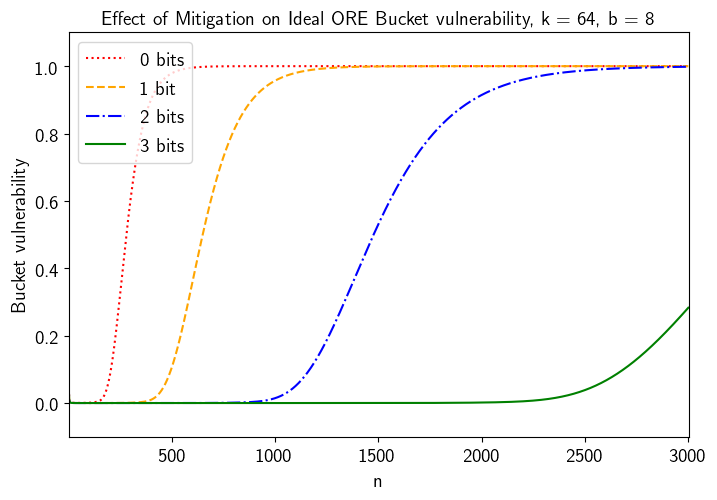

In [150]:
graph_it_mit_range_buck(n_range, df_brange_buck)

### Ideal Bucketing

In [9]:
n_list = [500, 1000, 1500, 2000, 2500, 3000]
b_list = [512, 256, 128, 64, 32, 16, 8, 4, 2]

In [ ]:
v_list = 